# Chest Cancer Dataset EDA
This notebook analyzes the distribution and properties of the Chest Cancer Image Classification dataset.

In [28]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib

In [29]:
# Configuration
data_dir = r"c:\Users\asidd\Desktop\Data_science_projects\MLOps\portfolio_projects\chest_cancer_image_classification\data"
splits = ["train", "test"]
classes = ["adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib", 
           "large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa", 
           "normal", 
           "squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa"]

In [30]:
# Data Collection
report = []

for split in splits:
    split_dir = os.path.join(data_dir, split)
    if not os.path.exists(split_dir):
        print(f"Skipping {split}, not found")
        continue
        
    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        if os.path.isdir(cls_dir):
            files = os.listdir(cls_dir)
            
            # Analyze image dimensions
            widths = []
            heights = []
            valid_extensions = 0
            
            for f in files:
                ext = f.split('.')[-1].lower()
                if ext in ['png', 'jpg', 'jpeg']:
                    valid_extensions += 1
                    try:
                        with Image.open(os.path.join(cls_dir, f)) as img:
                            w, h = img.size
                            widths.append(w)
                            heights.append(h)
                    except:
                        pass
            
            avg_width = sum(widths)/len(widths) if widths else 0
            avg_height = sum(heights)/len(heights) if heights else 0
            
            report.append({
                "Split": split,
                "Class": cls,
                "Count": len(files),
                "Valid Images": valid_extensions,
                "Avg Width": avg_width,
                "Avg Height": avg_height
            })

df = pd.DataFrame(report)
df

,Split,Class,Count,Valid Images,Avg Width,Avg Height
0,train,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib,195,195,385.574359,258.266667
1,train,large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa,115,115,398.530435,259.739130
2,train,normal,148,148,572.243243,429.972973
3,train,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa,155,155,396.503226,271.380645
4,test,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib,23,23,383.434783,248.086957
5,test,large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa,21,21,373.904762,239.380952
6,test,normal,67,67,640.626866,478.567164
7,test,squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa,15,15,390.466667,261.466667


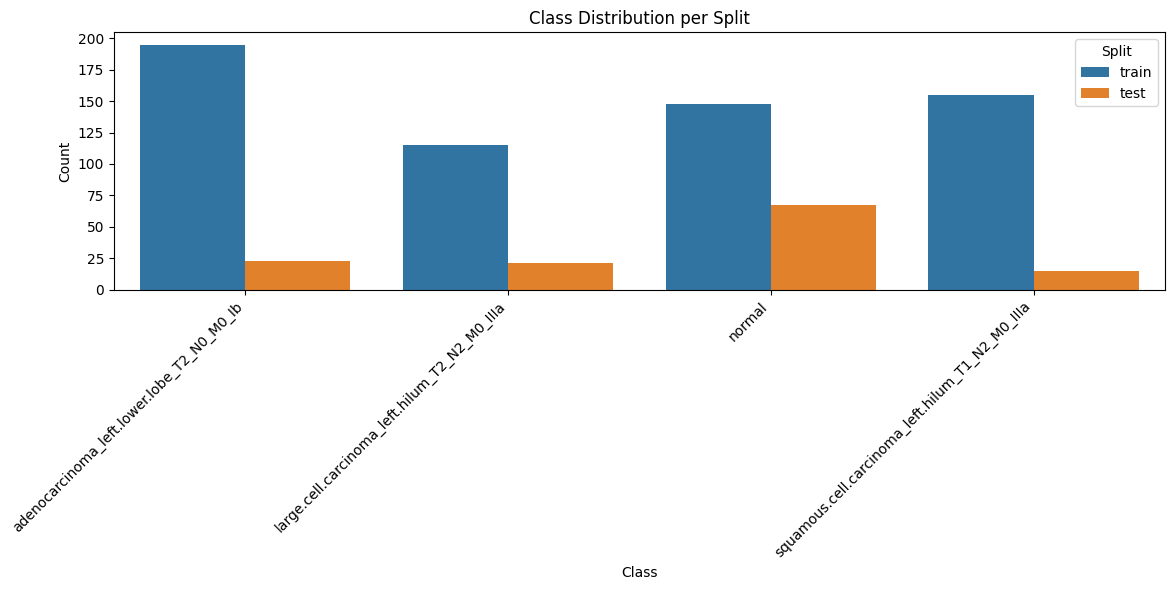

In [31]:
# Visualization: Class Distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Class', y='Count', hue='Split')
plt.title('Class Distribution per Split')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Duplicate Image Detection
Checking for duplicate images using MD5 hashing.

In [32]:
def calculate_md5(file_path):
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

all_hashes = {}
duplicates = []

for split in splits:
    split_dir = os.path.join(data_dir, split)
    if not os.path.exists(split_dir): continue
        
    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        if not os.path.isdir(cls_dir): continue
            
        files = os.listdir(cls_dir)
        for f in files:
            file_path = os.path.join(cls_dir, f)
            if os.path.isfile(file_path):
                try:
                    file_hash = calculate_md5(file_path)
                    if file_hash in all_hashes:
                        duplicates.append({
                            "Original": all_hashes[file_hash],
                            "Duplicate": f"{split}/{cls}/{f}",
                            "Split": split,
                            "Class": cls
                        })
                    else:
                        all_hashes[file_hash] = f"{split}/{cls}/{f}"
                except Exception as e:
                    pass

print(f"Found {len(duplicates)} duplicate images.")
if len(duplicates) > 0:
    print("\nExample Duplicates:")
    dup_df = pd.DataFrame(duplicates)
    display(dup_df.head(10))

Found 153 duplicate images.

Example Duplicates:


,Original,Duplicate,Split,Class
0,train/adenocarcinoma_left.lower.lobe_T2_N0_M0_...,train/adenocarcinoma_left.lower.lobe_T2_N0_M0_...,train,adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib
1,train/normal/10 (2) - Copy.png,train/normal/10 (2).png,train,normal
2,train/normal/10 - Copy (2) - Copy.png,train/normal/10 - Copy (2).png,train,normal
3,train/normal/10 - Copy - Copy.png,train/normal/10 - Copy.png,train,normal
4,train/normal/10 - Copy (3).png,train/normal/10.png,train,normal
5,train/normal/11 (2) - Copy.png,train/normal/11 (2).png,train,normal
6,train/normal/11 - Copy (2) - Copy.png,train/normal/11 - Copy (2).png,train,normal
7,train/normal/11 - Copy - Copy.png,train/normal/11 - Copy.png,train,normal
8,train/normal/11 - Copy (3).png,train/normal/11.png,train,normal
9,train/normal/12 (2) - Copy.png,train/normal/12 (2).png,train,normal


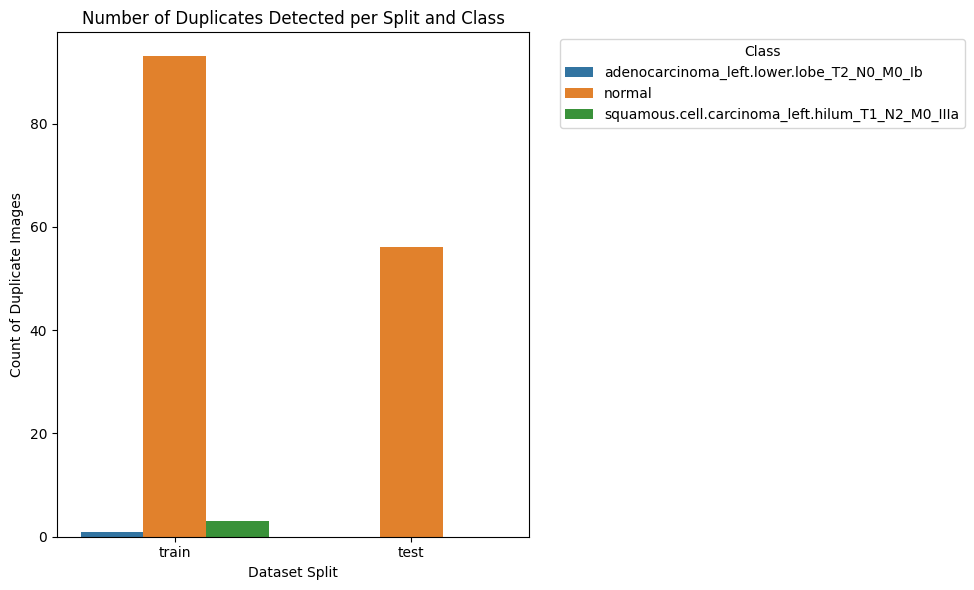

In [33]:
# Visualization: Duplicates per Folder/Class
if len(duplicates) > 0:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dup_df, x='Split', hue='Class')
    plt.title('Number of Duplicates Detected per Split and Class')
    plt.xlabel('Dataset Split')
    plt.ylabel('Count of Duplicate Images')
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No duplicates to visualize.")

## Class Specific Counts

In [34]:
# Create pivot table for readability (All Classes)
pivot_table = df.pivot(index='Class', columns='Split', values='Count')

# Reorder columns for logical flow
pivot_table = pivot_table[['train', 'test']]

print("Image Counts for All Classes:")
display(pivot_table)

Image Counts for All Classes:


Split,train,test
Class,,
adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib,195,23
large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa,115,21
normal,148,67
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa,155,15


In [ ]:
https://drive.google.com/file/d/1vWDeW9_Ew96WyTYgpOpQcFrHFdsSFOZj/view?usp=sharing